In [1]:
# a. Import required libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# ------------------------------------------------------------
# b. Load and preprocess CIFAR-10 dataset
# ------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
# Normalize images (0–255 → 0–1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
# ------------------------------------------------------------
# c. Load pre-trained CNN (VGG16 trained on ImageNet)
# ------------------------------------------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Freeze the lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# ------------------------------------------------------------
# d. Add custom classifier layers
# ------------------------------------------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # CIFAR-10: 10 classes
])


In [8]:
# ------------------------------------------------------------
# e. Compile model (initial training of top classifier layers)
# ------------------------------------------------------------
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# ------------------------------------------------------------
# f. Train the model (frozen convolutional base)
# ------------------------------------------------------------
history_1 = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=64,
                      validation_split=0.1,
                      verbose=1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.4091 - loss: 1.6506 - val_accuracy: 0.5648 - val_loss: 1.2304
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5439 - loss: 1.2938 - val_accuracy: 0.5842 - val_loss: 1.1666
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5648 - loss: 1.2336 - val_accuracy: 0.5876 - val_loss: 1.1412
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5794 - loss: 1.1897 - val_accuracy: 0.6058 - val_loss: 1.1200
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5913 - loss: 1.1574 - val_accuracy: 0.6146 - val_loss: 1.1042
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6019 - loss: 1.1260 - val_accuracy: 0.6106 - val_loss: 1.1094
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6103 - loss: 1.1018 - val_accuracy: 0.6228 - val_loss: 1.0861
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6159 - loss: 1.0855 - 

In [10]:
# ------------------------------------------------------------
# g. Evaluate after initial training
# ------------------------------------------------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("\nBefore Fine-tuning:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Before Fine-tuning:
Test Loss: 1.0954961776733398
Test Accuracy: 0.6162999868392944


In [11]:
# ------------------------------------------------------------
# h. Fine-tune: Unfreeze deeper layers & lower learning rate
# ------------------------------------------------------------
# Unfreeze last 4 convolutional blocks for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [12]:
# Recompile with smaller learning rate (critical for fine-tuning)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# ------------------------------------------------------------
# i. Continue training (fine-tuning)
# ------------------------------------------------------------
history_2 = model.fit(x_train, y_train,
                      epochs=2,
                      batch_size=64,
                      validation_split=0.1,
                      verbose=1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - accuracy: 0.6638 - loss: 0.9571 - val_accuracy: 0.7028 - val_loss: 0.8434
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.7435 - loss: 0.7237 - val_accuracy: 0.7316 - val_loss: 0.7742


In [14]:
# ------------------------------------------------------------
# j. Evaluate after fine-tuning
# ------------------------------------------------------------
test_loss_ft, test_acc_ft = model.evaluate(x_test, y_test, verbose=0)
print("\nAfter Fine-tuning:")
print("Test Loss:", test_loss_ft)
print("Test Accuracy:", test_acc_ft)


After Fine-tuning:
Test Loss: 0.80195552110672
Test Accuracy: 0.7172999978065491


In [15]:
# ------------------------------------------------------------
# k. Plot training & validation accuracy/loss for both phases
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [16]:
# Combine histories
train_acc = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
train_loss = history_1.history['loss'] + history_2.history['loss']
val_loss = history_1.history['val_loss'] + history_2.history['val_loss']

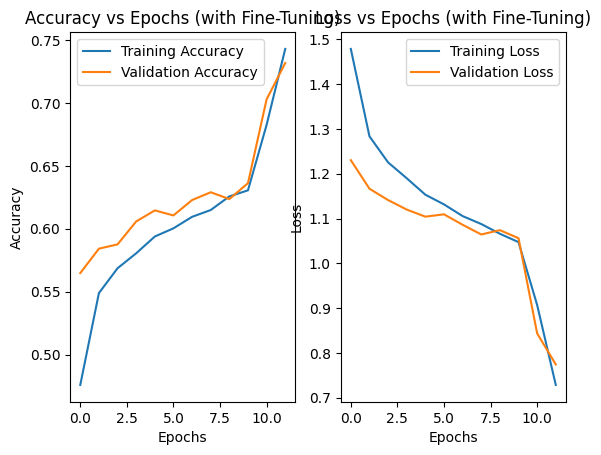

In [17]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Accuracy vs Epochs (with Fine-Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Loss vs Epochs (with Fine-Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [18]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [19]:
# Predict on some test samples
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


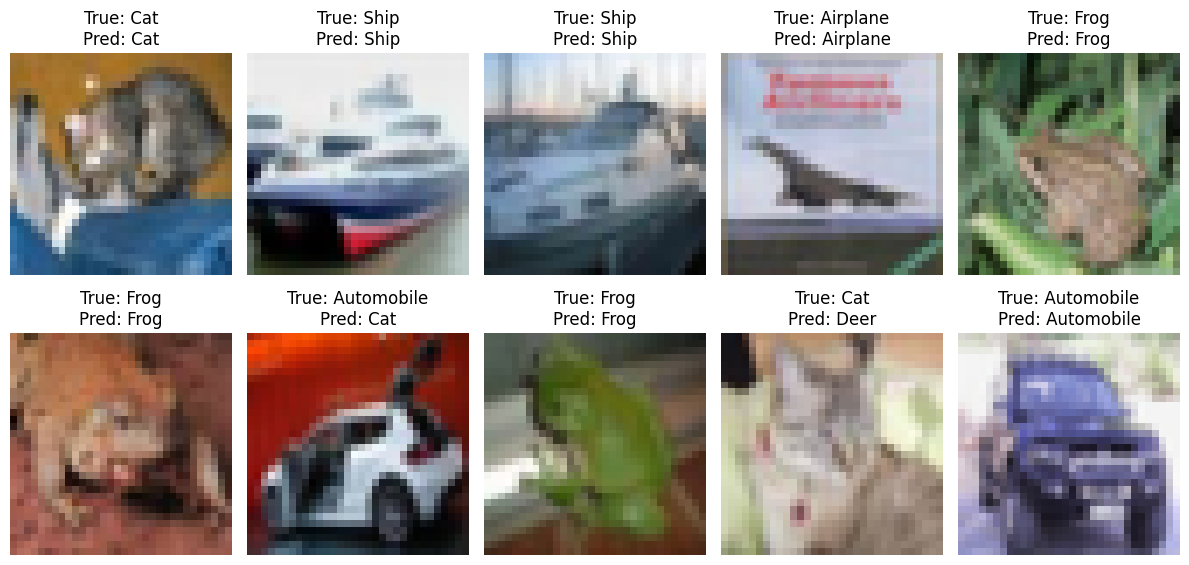

In [20]:
# Show 10 images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()